In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from pts.modules import StudentTOutput

from TsT import TsTEstimator

/home/kashif/.env/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/kashif/.env/pytorch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
dataset = get_dataset("solar_nips", regenerate=False)
train_grouper = MultivariateGrouper(
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
)

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test) / len(dataset.train)),
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
)
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [49]:
estimator = TsTEstimator(
    # distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length * 2,
    freq=dataset.metadata.freq,
    scaling="mean",
    max_pool=True,
    depth=2,
    dim=32,
    patch_size=(3, 11),
    batch_size=128,
    num_batches_per_epoch=200,
    trainer_kwargs=dict(accelerator="cuda", max_epochs=200, precision="bf16"),
)

In [ ]:
predictor = estimator.train(
    training_data=dataset_train,
    cache_data=True,
    shuffle_buffer_length=1024,
)

/home/kashif/.env/pytorch/lib/python3.10/site-packages/lightning_fabric/connector.py:562: UserWarning: bf16 is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.h

Training: 0it [00:00, ?it/s]

Epoch 0, global step 200: 'train_loss' reached 4.66626 (best 4.66626), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_131/checkpoints/epoch=0-step=200.ckpt' as top 1
Epoch 1, global step 400: 'train_loss' reached 3.45532 (best 3.45532), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_131/checkpoints/epoch=1-step=400.ckpt' as top 1
Epoch 2, global step 600: 'train_loss' reached 3.23449 (best 3.23449), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_131/checkpoints/epoch=2-step=600.ckpt' as top 1
Epoch 3, global step 800: 'train_loss' reached 3.14410 (best 3.14410), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_131/checkpoints/epoch=3-step=800.ckpt' as top 1
Epoch 4, global step 1000: 'train_loss' reached 3.10074 (best 3.10074), saving model to '/mnt/scratch/kashif/ConvTS-Mixer/lightning_logs/version_131/checkpoints/epoch=4-step=1000.ckpt' as top 1
Epoch 5, global step 1200: 'train_loss

In [53]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_test, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)

In [54]:
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

In [55]:
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))


Running evaluation: 7it [00:00, 73.37it/s]

Running evaluation: 7it [00:00, 112.53it/s]

Running evaluation: 7it [00:00, 112.46it/s]

Running evaluation: 7it [00:00, 111.98it/s]

Running evaluation: 7it [00:00, 111.91it/s]

Running evaluation: 7it [00:00, 112.53it/s]

Running evaluation: 7it [00:00, 112.09it/s]

Running evaluation: 7it [00:00, 112.54it/s]

Running evaluation: 7it [00:00, 111.94it/s]

Running evaluation: 7it [00:00, 112.28it/s]

Running evaluation: 7it [00:00, 112.02it/s]

Running evaluation: 7it [00:00, 111.81it/s]

Running evaluation: 7it [00:00, 111.91it/s]

Running evaluation: 7it [00:00, 112.03it/s]

Running evaluation: 7it [00:00, 112.13it/s]

Running evaluation: 7it [00:00, 111.96it/s]

Running evaluation: 7it [00:00, 112.65it/s]

Running evaluation: 7it [00:00, 112.12it/s]

Running evaluation: 7it [00:00, 111.98it/s]

Running evaluation: 7it [00:00, 112.17it/s]

Running evaluation: 7it [00:00, 112.68it/s]

Running evaluation: 7it [00:00, 112.17it/s]

Running ev

In [9]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

print("CRPS-SUM: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))

CRPS: 0.37301699376749126
ND: 0.5348959623609707
NRMSE: 1.0058282593874464
MSE: 959.6778119544334


In [56]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

print("CRPS-SUM: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))

CRPS: 0.34306427610079776
ND: 0.48367376729546935
NRMSE: 0.9935673002436383
MSE: 936.4236359090742
CRPS-SUM: 0.29183620800747584


[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15


In [41]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

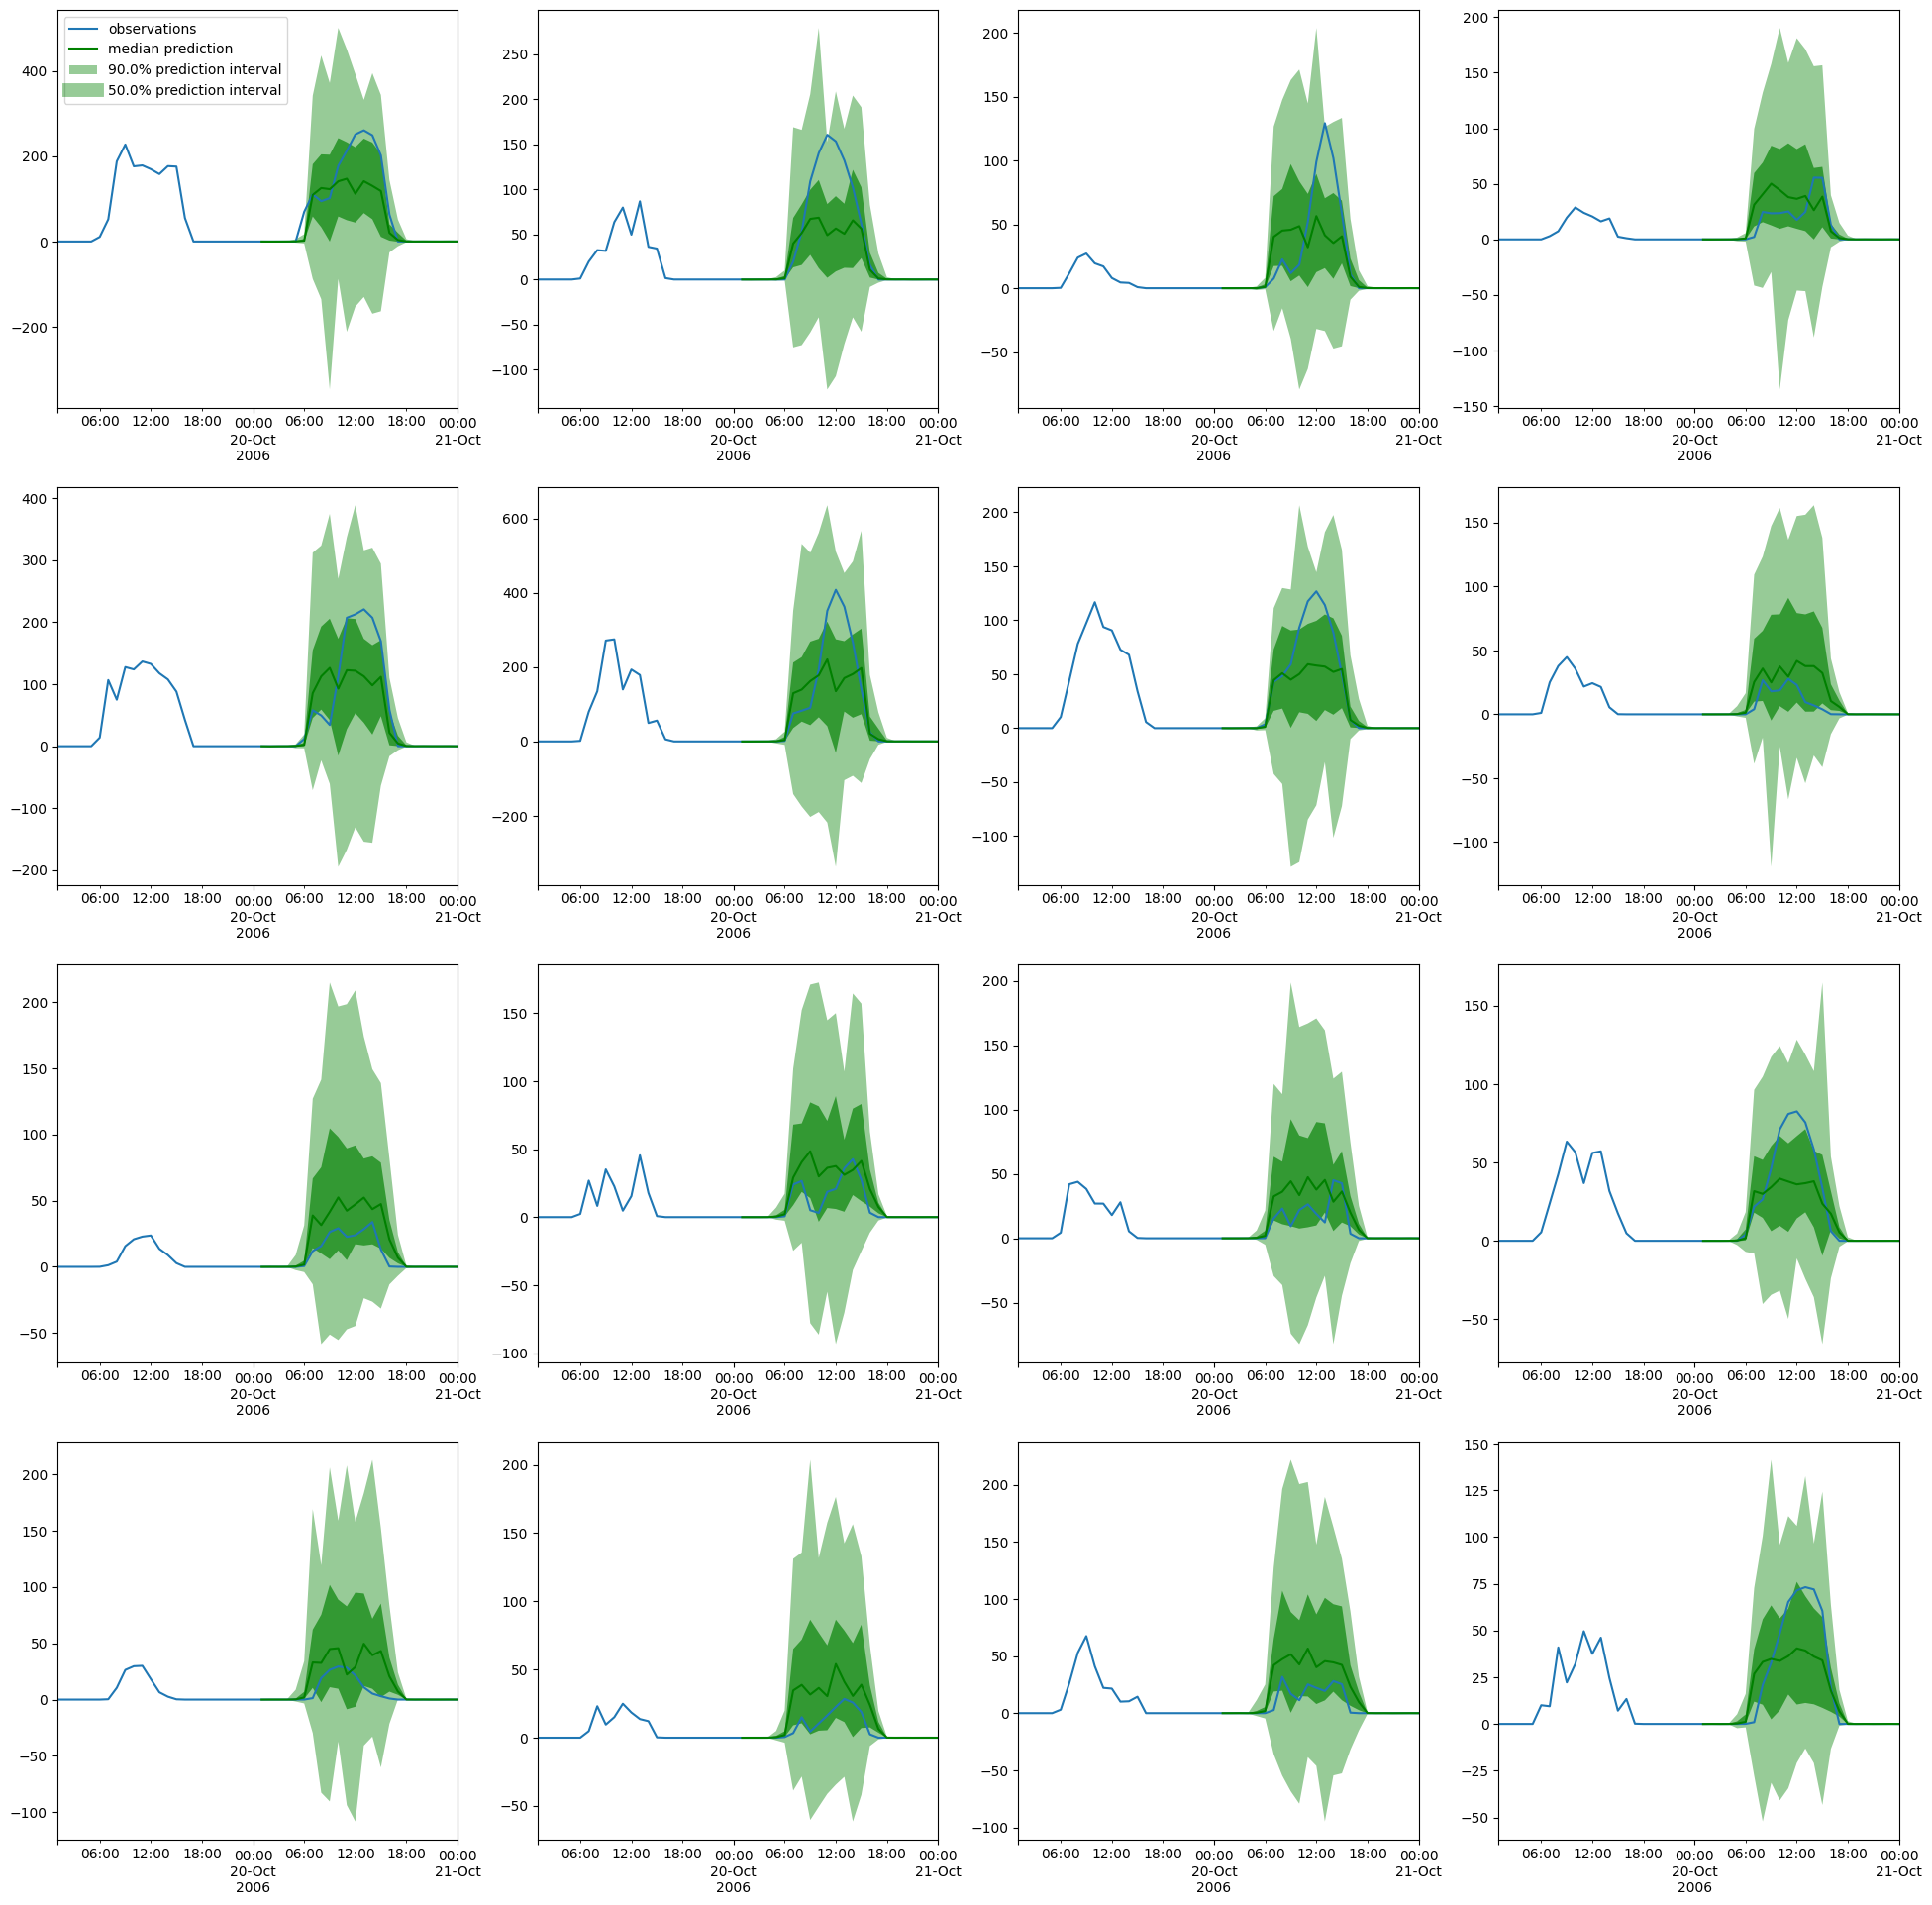

In [42]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()